In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

In [ ]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})
movies = movies.map(lambda x: x["movie_title"])

In [3]:
# Handelling timestemp feature
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

In [4]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )

    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [5]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [6]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [7]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = MovieModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [8]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(
        query_embeddings, movie_embeddings, compute_metrics=not training)

In [9]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [10]:
num_epochs = 300

model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.27.


In [11]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.29.


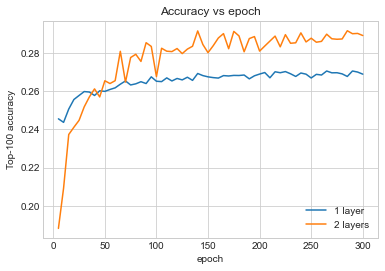

In [12]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [13]:
model = MovielensModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.28.


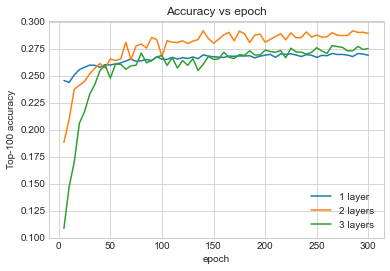

In [14]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()